# GRT Parallel Processing

In this notebook we will test the parallel processing for GRT

The following two lines are very important for getting the code working as expected in a multicore machine.  Since numpy uses OpenMP to compute matricial operations, the program normally spawns child processes to perform those operations.  As a result if you use multiprocessing (mp), besides the processes retrieved by mp, it will start 4 NP processes.  To avoid this, you just need to set this variable.

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [2]:
from gravray import *
from gravray.util import *
from gravray.sampling import *
from gravray.spice import *
from gravray.orbit import *
from gravray.stats import *

import gc
from tqdm import tqdm
import pandas as pd
import multiprocessing as mp
from itertools import product as cartesian

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%matplotlib nbagg

## Initialize

In [4]:
Spice.loadKernels()
NP=mp.cpu_count()-1
print("Available number of processors: ",NP)

Available number of processors:  3


## Common data

In [ ]:
bodyid="EARTH"
body=Body(bodyid)

## Parallel function

In [ ]:
NRAYS=0
FREQ=10000
def rayProcessing(initial,nw=0):
    global NRAYS,FREQ
    t=initial[0]
    site=initial[1]
    direction=initial[2]
    ray=GrtRay(site,direction[0][0],direction[0][1],direction[1])
    ray.updateRay(t)
    try:
        ray.propagateRay(t)
        detJ=ray.calcJacobianDeterminant()
    except AssertionError as e:
        detJ=0
    raydf=ray.packRay()
    raydf["detJ"]=detJ
    del ray
    NRAYS+=1
    if (NRAYS%FREQ)==1:
        unreachable=gc.collect()
        print(f"Completed rays by worker {nw}: {NRAYS} (unreachable {unreachable})")
        elTime(start=True)
    return raydf
    
def rayProcessingMulti(initials,nw=0):
    print(f"Processing {len(initials)} initial conditions in worker {nw}")
    raydfs=[rayProcessing(initial,nw=nw) for initial in initials]
    return raydfs

allrays=pd.DataFrame()
def joinResults(raydfs):
    global allrays
    allrays=pd.concat((allrays,)+tuple(raydfs))
    del raydfs
    gc.collect()

## Test data

In [ ]:
ts=[Spice.str2t("02/15/2013 03:20:34 UTC")]
siteprops=[[61.1*Angle.Deg,54.8*Angle.Deg,23.3*Const.km]]
sites=[]
for siteprop in siteprops:
    sites+=[Location(body,siteprop[0],siteprop[1],siteprop[2])]
directions=[[[101.1*Angle.Deg,15.9*Angle.Deg],-18.6*Const.km/Const.s]]

#List of conditions
initials=list(cartesian(*[ts,sites,directions]))
r=rayProcessingMulti(initials)
r

In [ ]:
print(r[0][['et','ximp', 'yimp', 'zimp','vximp', 'vyimp', 'vzimp']].values*np.array([1]+[1/1e3]*6))

In [ ]:
print(r[0][['q','e', 'i', 'W','w', 'M']])

## Massive input data

In [ ]:
#Numbers
Ntimes=Nsites=Npoints=Nvels=3
"""
Ntimes=365
Nsites=100
Npoints=100
Nvels=50
#"""

#Times
print("Preparing times...")
tini=Spice.str2t("02/15/2013 03:20:34")
tend=tini+Const.Year
ts=np.linspace(tini,tend,10)

#Sites
print("Preparing sites...")
elTime(0)
H=23.3*Const.km
points=Sample(Nsites)
points.genUnitSphere()
siteprops=np.zeros((Nsites,3))
siteprops[:,:2]=points.pp[:,1:]
siteprops[:,2]=H*np.ones(Nsites)
sites=[]
for siteprop in siteprops:
    sites+=[Location(body,siteprop[0],siteprop[1],siteprop[2])]
elTime()

#Directions
print("Preparing directions...")
elTime(0)
gpoints=Sample(Npoints)
gpoints.genUnitHemisphere()
speeds=-np.linspace(11.2,72.0,Nvels)*Const.km/Const.s
directions=list(cartesian(*[gpoints.pp[:,1:].tolist(),speeds]))
elTime()

#Initial conditions
print("Preparing initial conditions...")
elTime(0)
initials=list(cartesian(*[ts,sites,directions]))
elTime()

Ninitials=len(initials)
print(f"Number of initial conditions: {Ninitials} = {len(ts)}(ts)*{len(sites)}(sites)*{len(directions)}(dirs)")

## Chunking and computing time estimations

In [ ]:
#Computing time estimations
print(f"Sequential processing of {Ninitials} rays:")
dt,dtu=elTime(0)
tinitials=initials[:10]
rays=rayProcessingMulti(tinitials)
dt,dtu=elTime()
tpray=dt/len(tinitials)
tupray=tUnit(tpray)
totrays=tpray*Ninitials
toturays=tUnit(totrays)
print(f"Total duration: {dtu[0]} {dtu[1]}, Duration per ray: {tupray[0]} {tupray[1]}")

#Chunks
npchunk=np.int(np.ceil(Ninitials/NP))
cinitials=[initial for initial in Util.chunkList(initials,npchunk)]
Nchunks=len(cinitials)
FREQ=np.int(npchunk/10)
print(f"{Nchunks} chunks containing {npchunk} initial conditions (showed with frequency {FREQ})")
tchunk=tpray*npchunk
tchunku=tUnit(tchunk)
print()
print(f"Estimated total: {toturays[0]} {toturays[1]}")

print(f"Estimated time per chunk (estimated parallel): {tchunku[0]} {tchunku[1]}")

## Parallel processing

In [ ]:
allrays=pd.DataFrame()
pool=mp.Pool(processes=NP)
elTime(0)
[pool.apply_async(rayProcessingMulti,args=(inis,nw),callback=joinResults) for nw,inis in enumerate(cinitials)]
pool.close()
pool.join()
elTime()

In [ ]:
print("Number of results:",len(allrays))

In [ ]:
allrays.to_csv("rays_parallel.csv",index=False,float_format='%.17e')

--End--

## Postprocessing

In [50]:
data=pd.read_csv("../tmp/rays_parallel_earth.csv.gz",compression='gzip')
print(f"Read {len(data)} conditions...")

Read 500000 conditions...


In [51]:
#data.to_csv("../tmp/rays_parallel.csv.gz",compression='gzip',index=False,float_format='%.17e')
#np.savetxt("../tmp/rays_parallel.dat",data.values,fmt="%.17e")

In [52]:
test=data.head(1)

In [53]:
print(test[['et','ximp', 'yimp', 'zimp','vximp', 'vyimp', 'vzimp']].values*np.array([1]+[1/1e3]*6))

[[ 4.17676738e+08 -1.48287758e+08 -1.86075796e+07 -1.06098183e+04
  -2.12554395e+00 -6.38233713e+01  1.17527732e+01]]


In [54]:
print(test[['q','e', 'i', 'W','w', 'M']])

          q         e         i           W           w          M
0  0.986016  3.486752  9.964305  187.176048  349.476678  17.642489


In [58]:
dt=elTime(0)
f=open("../tmp/gravray-include-earth.sh","w")
empty=""
for i in range(10):empty+=f"0\t"
nrays=len(data)
for i,index in enumerate(tqdm(data.index)):
    ray=data.loc[index]
    et=ray["et"]
    ximp=""
    for x in ray[['ximp','yimp','zimp','vximp','vyimp','vzimp']].values*np.array([1/1e3]*6):
        ximp+=f"{x:.17e} "
    f.write(f"echo 'ray {i}/{nrays}...';")
    f.write(f"rm ray$1.dat &> /dev/null;")
    f.write(f"./wherewillitbe.exe {ray['et']:.17e} {ximp} -1.0 2 \"$1\" &> /dev/null;")
    f.write(f'if [ $? -eq 0 -a "x$(cat ray$1.dat)" != "x" ];then results=$(tail -n 1 ray$1.dat);echo "$results {i}" >> orbits$1.dat;')
    f.write(f"else echo '{et:+.17e} {ximp} {empty} {i}' >> orbits$1.dat;")
    f.write(f"fi"+"\n")
f.close()
dt=elTime(1)

100%|██████████| 500000/500000 [11:41<00:00, 712.29it/s]


Elapsed time since last call: 11.7037 min


### Moon

In [311]:
data=pd.read_csv("../tmp/rays_parallel_moon.csv.gz",compression='gzip')
print(f"Read {len(data)} conditions...")

Read 500000 conditions...


In [312]:
test=data.head(1)
print(test[['et','ximp', 'yimp', 'zimp','vximp', 'vyimp', 'vzimp']].values*np.array([1]+[1/1e3]*6))
print(test[['q','e', 'i', 'W','w', 'M']])

[[ 4.21183042e+08 -1.03206994e+08 -1.10161518e+08  1.35801252e+04
   7.32429072e+01  5.46438262e+00  2.30754672e+01]]
          q         e          i           W          w           M
0  0.670376  4.147137  24.810815  226.856195  54.320662 -181.327076


In [304]:
dt=elTime(0)
f=open("../tmp/gravray-include-moon.sh","w")
empty=""
for i in range(10):empty+=f"0\t"
nrays=len(data)
for i,index in enumerate(tqdm(data.index)):
    ray=data.loc[index]
    et=ray["et"]
    ximp=""
    for x in ray[['ximp','yimp','zimp','vximp','vyimp','vzimp']].values*np.array([1/1e3]*6):
        ximp+=f"{x:.17e} "
    f.write(f"echo 'ray {i}/{nrays}...';")
    f.write(f"rm ray$1.dat &> /dev/null;")
    f.write(f"./wherewillitbe.exe {ray['et']:.17e} {ximp} -1.0 2 \"$1\" &> /dev/null;")
    f.write(f'if [ $? -eq 0 -a "x$(cat ray$1.dat)" != "x" ];then results=$(tail -n 1 ray$1.dat);echo "$results {i}" >> orbits$1.dat;')
    f.write(f"else echo '{et:+.17e} {ximp} {empty} {i}' >> orbits$1.dat;")
    f.write(f"fi"+"\n")
f.close()
dt=elTime(1)

100%|██████████| 500000/500000 [14:45<00:00, 564.38it/s]  


Elapsed time since last call: 14.7674 min


## Earth comparison

In [340]:
dt=elTime(0)
#Read GRT2 results
data_grt2=pd.read_csv("../tmp/rays_parallel_earth.csv.gz",compression='gzip')
print(f"{len(data_grt2)} points for GRT2")
#Read GRT1 results
grt1_columns=["et","x","y","z","vx","vy","vz","r","v","q","e","i","W","w","M","t0","mu","iray"]
raw_grt1=np.loadtxt("../tmp/orbits-earth.dat.gz")
data_grt1=pd.DataFrame(raw_grt1,columns=grt1_columns)
data_grt1=data_grt1.astype({'iray':'int32'})
data_grt1.set_index("iray",inplace=True)
data_grt1.sort_index(inplace=True)
data_grt1["q"]/=(Const.au/Const.km)
data_grt1["M"]=np.mod(data_grt1["M"],360.0)
print(f"{len(data_grt1)} points for GRT1")

500000 points for GRT2
500000 points for GRT1


In [341]:
#Merging dataframes
print("Merging...")
data_grt=deepcopy(data_grt2)
ecols=['q', 'e', 'i', 'W', 'w', 'M']
ncols2=dict()
ncols1=[]
for col in data_grt.columns:
    if col in ecols:
        ncols2.update({col:col+"_any"})
        ncols1+=[col+"_num"]
    else:
        ncols.update({col:col})
data_grt.rename(columns=ncols2,inplace=True)
data_grt[ncols1]=data_grt1[ecols]
dt=elTime(1)
#print("First row:",data_grt.iloc[0])

Merging...
Elapsed time since last call: 1.09686 min


In [342]:
dt=elTime(0)
data_grt["DZ"]=-1
data_coll=pd.DataFrame([],columns=data_grt.columns)
icoll=0
drop=[]
for i,index in enumerate(tqdm(data_grt2.index)):
    E1=data_grt1.loc[index][["q","e","i","W","w","M"]].values*np.array([1,1,Angle.Deg,Angle.Deg,Angle.Deg,Angle.Deg])
    E2=data_grt2.loc[index][["q","e","i","W","w","M"]].values*np.array([1,1,Angle.Deg,Angle.Deg,Angle.Deg,Angle.Deg])
    if E1[0]==0 or E2[0]==0:
        #print(f"Collision in {index}...")
        data_coll=data_coll.append(data_grt.loc[index])
        drop+=[index]
        icoll+=1
        #if icoll>3:break
        continue
    #print("Numerical:",E1)
    #print("Analytical:",E2)
    Dz=Spice.zappalaDistance(E1[:5],E2[:5])
    data_grt.loc[index,"DZ"]=Dz
    #if index>100:break
dt=elTime(1)
#Drop collisions
data_grt=data_grt.drop(drop)
print(f"Remaining rays: {len(data_grt)}")
print(f"Dropped rays: {len(data_coll)}")

100%|██████████| 500000/500000 [24:28<00:00, 340.49it/s]  


Elapsed time since last call: 24.475 min
Remaining rays: 482947
Dropped rays: 17053


In [256]:
data_grt["DZ"].describe()

count    482947.000000
mean          0.007552
std           0.012839
min           0.000022
25%           0.003061
50%           0.005477
75%           0.009389
max           1.734824
Name: DZ, dtype: float64

In [266]:
def medHistogram(data,**args):
    h,x=np.histogram(data,**args)
    xm=(x[1:]+x[:-1])/2
    return h,xm

<IPython.core.display.Javascript object>


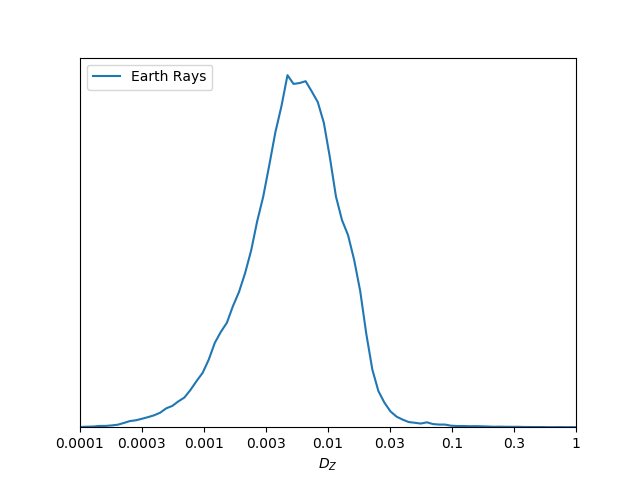

In [278]:
fig=plt.figure()
ax=fig.gca()
hp,xp=medHistogram(np.log10(data_grt["DZ"].values),bins=100,density=True)

ax.plot(xp,hp,label="Earth Rays")

xmin,xmax=ax.get_xlim()
ymin,ymax=ax.get_ylim()

ax.set_xlim((-4,0))
ax.set_ylim((0,ymax))

xts=ax.get_xticks()
xtl=[]
for xt in xts:
    xtl+=[f"{10**xt:.1g}"]
ax.set_xticklabels(xtl)
ax.set_yticks([])
ax.set_xlabel(r"$D_Z$")
ax.legend(loc='upper left')

## Moon comparison

In [293]:
dt=elTime(0)
obj="moon"
#Read GRT2 results
mdata_grt2=pd.read_csv(f"../tmp/rays_parallel_{obj}.csv.gz",compression='gzip')

In [295]:
grt1_columns=["et","x","y","z","vx","vy","vz","r","v","q","e","i","W","w","M","t0","mu","iray"]
raw_grt1=np.loadtxt(f"../tmp/orbits-{obj}.dat.gz")
mdata_grt1=pd.DataFrame(raw_grt1,columns=grt1_columns)

In [297]:
mdata_grt1=mdata_grt1.astype({'iray':'int32'})

In [300]:
mdata_grt1.set_index("iray",inplace=True)

In [302]:
mdata_grt1.sort_index(inplace=True)

In [305]:
dt=elTime(0)
obj="moon"
#Read GRT2 results
mdata_grt2=pd.read_csv(f"../tmp/rays_parallel_{obj}.csv.gz",compression='gzip')
print(f"{len(data_grt2)} points for GRT2")
#Read GRT1 results
grt1_columns=["et","x","y","z","vx","vy","vz","r","v","q","e","i","W","w","M","t0","mu","iray"]
raw_grt1=np.loadtxt(f"../tmp/orbits-{obj}.dat.gz")
mdata_grt1=pd.DataFrame(raw_grt1,columns=grt1_columns)
mdata_grt1=mdata_grt1.astype({'iray':'int32'})
mdata_grt1.set_index("iray",inplace=True)
mdata_grt1.sort_index(inplace=True)
mdata_grt1["q"]/=(Const.au/Const.km)
mdata_grt1["M"]=np.mod(data_grt1["M"],360.0)
print(f"{len(mdata_grt1)} points for GRT1")

500000 points for GRT2
500000 points for GRT1


In [306]:
#Merging dataframes
print("Merging...")
mdata_grt=deepcopy(mdata_grt2)
ecols=['q', 'e', 'i', 'W', 'w', 'M']
ncols2=dict()
ncols1=[]
for col in mdata_grt.columns:
    if col in ecols:
        ncols2.update({col:col+"_any"})
        ncols1+=[col+"_num"]
    else:
        ncols.update({col:col})
mdata_grt.rename(columns=ncols2,inplace=True)
mdata_grt[ncols1]=mdata_grt1[ecols]
dt=elTime(1)
#print("First row:",data_grt.iloc[0])

Merging...
Elapsed time since last call: 1.08161 min


In [308]:
dt=elTime(0)
mdata_grt["DZ"]=-1
mdata_coll=pd.DataFrame([],columns=mdata_grt.columns)
icoll=0
drop=[]
for i,index in enumerate(tqdm(mdata_grt2.index)):
    E1=mdata_grt1.loc[index][["q","e","i","W","w","M"]].values*np.array([1,1,Angle.Deg,Angle.Deg,Angle.Deg,Angle.Deg])
    E2=mdata_grt2.loc[index][["q","e","i","W","w","M"]].values*np.array([1,1,Angle.Deg,Angle.Deg,Angle.Deg,Angle.Deg])
    if E1[0]==0 or E2[0]==0:
        #print(f"Collision in {index}...")
        mdata_coll=mdata_coll.append(mdata_grt.loc[index])
        drop+=[index]
        icoll+=1
        #if icoll>3:break
        continue
    #print("Numerical:",E1)
    #print("Analytical:",E2)
    Dz=Spice.zappalaDistance(E1[:5],E2[:5])
    mdata_grt.loc[index,"DZ"]=Dz
    #if index>100:break
dt=elTime(1)
#Drop collisions
mdata_grt=mdata_grt.drop(drop)
print(f"Remaining rays: {len(mdata_grt)}")
print(f"Dropped rays: {len(mdata_coll)}")

100%|██████████| 500000/500000 [23:15<00:00, 358.34it/s] 


Elapsed time since last call: 23.2556 min
Remaining rays: 497903
Dropped rays: 2097


In [317]:
mdata_back=deepcopy(mdata_grt)

In [318]:
mdata_grt_bound=mdata_grt[mdata_grt["e_any"]<1]

In [332]:
list(ncols2.values())

['q_any', 'e_any', 'i_any', 'W_any', 'w_any', 'M_any']

In [337]:
mdata_grt_bound.sort_values(by="DZ",ascending=False)[ncols1+list(ncols2.values())+["DZ"]]

,q_num,e_num,i_num,W_num,w_num,M_num,q_any,e_any,i_any,W_any,w_any,M_any,DZ
165695,0.017823,0.693279,81.696315,2.760722,10.359611,329.301855,0.020902,0.963719,82.049127,7.162005,5.671463,103.322080,1.758078
36892,0.017995,0.756587,151.065525,271.327635,183.808192,326.297460,0.021119,0.963238,152.510424,265.515359,185.162309,109.325675,1.601303
382337,0.020786,0.772541,32.939972,48.551241,355.743356,334.677440,0.024157,0.958008,33.301178,46.874270,5.779285,106.585455,1.481062
420817,0.009223,1.081637,8.726811,243.715827,10.208975,333.470096,0.005874,0.994426,8.915454,243.839296,353.660965,330.223253,1.193927
141657,0.030011,0.815504,153.750941,4.815015,10.370481,172.406625,0.034192,0.940388,154.176192,7.185305,6.832837,108.685082,1.068979
220177,0.018620,0.893947,4.060349,171.264304,350.828304,346.247234,0.017705,0.969255,3.793378,163.083497,5.343503,103.716087,0.992234
148894,0.038839,0.798326,9.144231,5.111527,350.063938,149.937268,0.042237,0.937767,9.113361,7.100922,348.362797,284.765166,0.991182
414934,0.013213,0.928131,19.578019,25.610213,181.019296,0.000000,0.012146,0.978941,18.559586,23.007223,184.509839,99.686358,0.944500
382483,0.033312,0.852479,150.592536,227.849364,159.948230,19.712512,0.036909,0.965482,150.510600,226.875387,164.015333,328.237866,0.926407
352160,0.024515,0.868830,15.868984,308.213955,178.197890,179.897444,0.027011,0.949224,14.967001,304.431899,177.512395,207.954858,0.915733


<IPython.core.display.Javascript object>


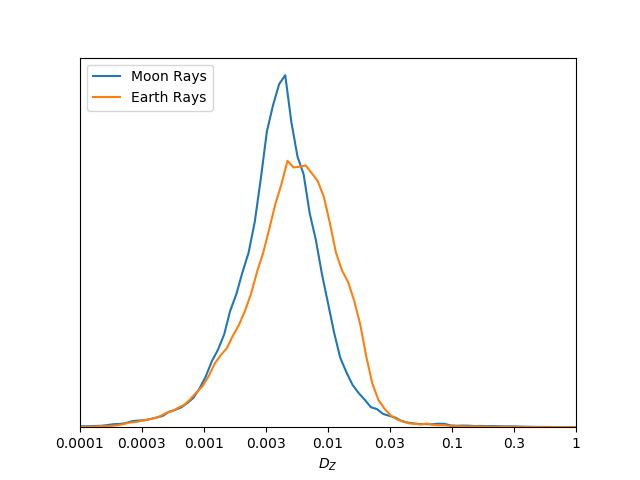

In [319]:
fig=plt.figure()
ax=fig.gca()
hpm,xpm=medHistogram(np.log10(mdata_grt_bound["DZ"].values),bins=100,density=True)

ax.plot(xpm,hpm,label="Moon Rays")
ax.plot(xp,hp,label="Earth Rays")

xmin,xmax=ax.get_xlim()
ymin,ymax=ax.get_ylim()

ax.set_xlim((-4,0))
ax.set_ylim((0,ymax))

xts=ax.get_xticks()
xtl=[]
for xt in xts:
    xtl+=[f"{10**xt:.1g}"]
ax.set_xticklabels(xtl)
ax.set_yticks([])
ax.set_xlabel(r"$D_Z$")
ax.legend(loc='upper left')

In [313]:
mdata_coll

,et,lon,lat,alt,A,h,v,ximp,yimp,zimp,...,a,n,detJ,q_num,e_num,i_num,W_num,w_num,M_num,DZ
193,421183042.0,73.859441,19.876874,23300.0,171.443856,32.005455,-40000.0,-1.032070e+11,-1.101615e+11,1.358013e+07,...,1.420352,1.176180e-07,-1.915662e-14,0.0,0.0,0.0,0.0,0.0,88.117458,-1.0
199,421183042.0,73.859441,19.876874,23300.0,171.443856,32.005455,-59200.0,-1.032070e+11,-1.101615e+11,1.358013e+07,...,-1.343024,1.279210e-07,1.879168e-14,0.0,0.0,0.0,0.0,0.0,340.461359,-1.0
202,421183042.0,73.859441,19.876874,23300.0,171.443856,32.005455,-68800.0,-1.032070e+11,-1.101615e+11,1.358013e+07,...,-0.561510,4.731851e-07,2.620510e-14,0.0,0.0,0.0,0.0,0.0,25.621286,-1.0
282,421183042.0,73.859441,19.876874,23300.0,1.474912,37.589503,-68800.0,-1.032070e+11,-1.101615e+11,1.358013e+07,...,-0.304878,1.182711e-06,1.733897e-14,0.0,0.0,0.0,0.0,0.0,303.888414,-1.0
389,421183042.0,73.859441,19.876874,23300.0,106.521497,46.886394,-27200.0,-1.032070e+11,-1.101615e+11,1.358013e+07,...,0.514910,5.388529e-07,-1.615813e-14,0.0,0.0,0.0,0.0,0.0,174.711996,-1.0
390,421183042.0,73.859441,19.876874,23300.0,106.521497,46.886394,-30400.0,-1.032070e+11,-1.101615e+11,1.358013e+07,...,0.516057,5.370580e-07,-1.151395e-14,0.0,0.0,0.0,0.0,0.0,279.032681,-1.0
550,421183042.0,73.859441,19.876874,23300.0,126.583609,62.873247,-30400.0,-1.032070e+11,-1.101615e+11,1.358013e+07,...,0.589529,4.398549e-07,-2.258434e-14,0.0,0.0,0.0,0.0,0.0,327.479158,-1.0
551,421183042.0,73.859441,19.876874,23300.0,126.583609,62.873247,-33600.0,-1.032070e+11,-1.101615e+11,1.358013e+07,...,0.608559,4.193857e-07,-7.275973e-15,0.0,0.0,0.0,0.0,0.0,224.158571,-1.0
700,421183042.0,211.367205,22.333683,23300.0,333.749755,1.719131,-62400.0,-1.032056e+11,-1.101588e+11,1.367514e+07,...,-0.631367,3.968672e-07,2.094006e-14,0.0,0.0,0.0,0.0,0.0,188.365371,-1.0
856,421183042.0,211.367205,22.333683,23300.0,353.811867,10.952784,-49600.0,-1.032056e+11,-1.101588e+11,1.367514e+07,...,-0.737973,3.140561e-07,1.404166e-14,0.0,0.0,0.0,0.0,0.0,325.242527,-1.0


In [338]:
!pwd

/Users/jzuluaga/GoogleDrive/ColaboratoryProjects/GRT2/GRT/dev


In [343]:
len(mdata_grt)

497903